# Dependency code

In [1]:
import imp
import os
import sys
import numpy as np
import glob
import cmdbench

fp, pathname, description = imp.find_module('benchmark', ['../lib'])
benchmark = imp.load_module('benchmark', fp, pathname, description)

# Summarize numpy array if it has more than 10 elements
np.set_printoptions(threshold=10)

# Software versions

In [2]:
sting_bin_dir = os.path.abspath('../lib/bin/STing')
os.environ['PATH'] = f"{sting_bin_dir}:{os.environ['PATH']}"

indexer_bin = f'{sting_bin_dir}/indexer'
typer_bin = f'{sting_bin_dir}/typer'
detector_bin = f'{sting_bin_dir}/detector'
db_util_bin = f'{sting_bin_dir}/db_util.py'
!{indexer_bin} --version
!{typer_bin} --version
!{detector_bin} --version
!{db_util_bin} --version

indexer version: 1.0.1
SeqAn version: 2.1.1
typer version: 1.0.0
SeqAn version: 2.1.1
detector version: 1.0.0
SeqAn version: 2.1.1
db_util.py
  version:	1.2.1
  last update:	07/09/2020


# Benchmark

## Input data and constants

In [3]:
input_dir = '../data/input-files/reads'
input_files_1 = [os.path.basename(f) for f in glob.glob(f'{input_dir}/*_1.fastq.gz')]
input_samples = [f.replace('_1.fastq.gz','') for f in input_files_1]
input_samples.sort()
print(input_samples)

sample_sizes = [1,10,20,30,40,50,60,70,80]

nproc = 32

sting_output = 'sting-output'
sting_db = 'sting-db'
scheme_name = 'Campylobacter jejuni'
scheme_db = f'{sting_db}/{scheme_name.lower().replace(" ", "_")}'
print(scheme_db)

benchmark.create_folder_if_doesnt_exist(sting_output)
benchmark.create_folder_if_doesnt_exist(sting_db)
benchmark.clean_if_exists(sting_db)
benchmark.clean_if_exists(sting_output)

['2014C-3598', '2014C-3599', '2014C-3600', '2014C-3655', '2014C-3656', '2014C-3840', '2014C-3850', '2014C-3857', '2014C-3907', '2014D-0067', '2014D-0068', '2014D-0070', '2014D-0189', 'CFSAN002349', 'CFSAN023463', 'CFSAN023464', 'CFSAN023465', 'CFSAN023466', 'CFSAN023467', 'CFSAN023468', 'CFSAN023469', 'CFSAN023470', 'CFSAN023471', 'D5663', 'D7316', 'D7319', 'D7320', 'D7321', 'D7322', 'D7323', 'D7324', 'D7327', 'D7328', 'D7329', 'D7330', 'D7331', 'D7333', 'D7334', 'MOD1_LS1000', 'MOD1_LS1003', 'MOD1_LS1004', 'MOD1_LS1005', 'MOD1_LS1006', 'MOD1_LS1008', 'MOD1_LS1009', 'MOD1_LS1010', 'MOD1_LS1011', 'MOD1_LS982', 'MOD1_LS985', 'MOD1_LS989', 'MOD1_LS994', 'MOD1_LS995', 'MOD1_LS996', 'MOD1_LS997', 'MOD1_LS998', 'PNUSA000194', 'PNUSA000195', 'PNUSA000196', 'PNUSAL000730', 'PNUSAL000870', 'PNUSAL000957', 'PNUSAL001024', 'SIM_CFSAN000189', 'SIM_CFSAN000191', 'SIM_CFSAN000211', 'SIM_CFSAN000212', 'SIM_CFSAN000228', 'SIM_CFSAN000661', 'SIM_CFSAN000669', 'SIM_CFSAN000700', 'SIM_CFSAN000752', 'SIM_

## Build STing MLST database

In [4]:
!{db_util_bin} fetch --query "Campylobacter jejuni" --out_dir {sting_db} --build_index

Database: "Campylobacter jejuni"
 Fetching allele sequences: 
 - https://rest.pubmlst.org/db/pubmlst_campylobacter_seqdef/loci/aspA/alleles_fasta -> /home/CSCScience.ca/apetkau/workspace/thesis-benchmarking/sting/sting-db/campylobacter_jejuni/aspA.fa
 - https://rest.pubmlst.org/db/pubmlst_campylobacter_seqdef/loci/glnA/alleles_fasta -> /home/CSCScience.ca/apetkau/workspace/thesis-benchmarking/sting/sting-db/campylobacter_jejuni/glnA.fa
 - https://rest.pubmlst.org/db/pubmlst_campylobacter_seqdef/loci/gltA/alleles_fasta -> /home/CSCScience.ca/apetkau/workspace/thesis-benchmarking/sting/sting-db/campylobacter_jejuni/gltA.fa
 - https://rest.pubmlst.org/db/pubmlst_campylobacter_seqdef/loci/glyA/alleles_fasta -> /home/CSCScience.ca/apetkau/workspace/thesis-benchmarking/sting/sting-db/campylobacter_jejuni/glyA.fa
 - https://rest.pubmlst.org/db/pubmlst_campylobacter_seqdef/loci/pgm/alleles_fasta -> /home/CSCScience.ca/apetkau/workspace/thesis-benchmarking/sting/sting-db/campylobacter_jejuni/pg

## Benchmark functions

In [5]:
def reset_func():
    benchmark.clean_if_exists(sting_output)

def sampling_func(sample_size):
    samples = input_samples[:sample_size]
    return samples

typer_command = {
    "command": f"typer -x {scheme_db}/db/index -1 {input_dir}/%_1.fastq.gz -2 {input_dir}/%_2.fastq.gz",
    "parallel_args": f"-j {nproc} -I%"
}

## Benchmark

In [6]:
multibench_results, debug_str = benchmark.multibench.multi_cmdbench({
        "type": [typer_command]
    },
    reset_func = reset_func, iterations = 1, sampling_func = sampling_func, sample_sizes = sample_sizes, 
    benchmark_list_to_results = benchmark.benchmark_list_to_results, active_output_print = True
)

>>>>>>>>>>>>>
parallel -j 32 -I% typer -x sting-db/campylobacter_jejuni/db/index -1 ../data/input-files/reads/%_1.fastq.gz -2 ../data/input-files/reads/%_2.fastq.gz ::: 2014C-3598

STDOUT: allelic_profile	no_kmer_hits	NA	NA	NA	NA	NA	NA	NA	NA	0	0	2014C-3598_1.fastq.gz,2014C-3598_2.fastq.gz

-------------
STDERR: Line_type	Status	ST	aspA	glnA	gltA	glyA	pgm	tkt	uncA	Total_k-mers	Total_reads	Input_files

<<<<<<<<<<<<<

>>>>>>>>>>>>>
parallel -j 32 -I% typer -x sting-db/campylobacter_jejuni/db/index -1 ../data/input-files/reads/%_1.fastq.gz -2 ../data/input-files/reads/%_2.fastq.gz ::: 2014C-3598 2014C-3599 2014C-3600 2014C-3655 2014C-3656 2014C-3840 2014C-3850 2014C-3857 2014C-3907 2014D-0067

STDOUT: allelic_profile	no_kmer_hits	NA	NA	NA	NA	NA	NA	NA	NA	0	0	2014C-3655_1.fastq.gz,2014C-3655_2.fastq.gz
allelic_profile	no_kmer_hits	NA	NA	NA	NA	NA	NA	NA	NA	0	0	2014C-3598_1.fastq.gz,2014C-3598_2.fastq.gz
allelic_profile	no_kmer_hits	NA	NA	NA	NA	NA	NA	NA	NA	0	0	2014C-3907_1.fastq.gz,2014C-3907_2

# Save and reload results

In [7]:
save_path = "string-results.txt"

samples_per_sample_size = []
for sample_size in sample_sizes:
        samples_per_sample_size.append(input_samples[:sample_size])

benchmark.multibench.save_multibench_results(multibench_results, samples_per_sample_size, save_path)

multibench_results, samples_per_sample_size = benchmark.multibench.read_multibench_results(save_path)
print(samples_per_sample_size)

[['2014C-3598'], ['2014C-3598,', '2014C-3599,', '2014C-3600,', '2014C-3655,', '2014C-3656,', '2014C-3840,', '2014C-3850,', '2014C-3857,', '2014C-3907,', '2014D-0067'], ['2014C-3598,', '2014C-3599,', '2014C-3600,', '2014C-3655,', '2014C-3656,', '2014C-3840,', '2014C-3850,', '2014C-3857,', '2014C-3907,', '2014D-0067,', '2014D-0068,', '2014D-0070,', '2014D-0189,', 'CFSAN002349,', 'CFSAN023463,', 'CFSAN023464,', 'CFSAN023465,', 'CFSAN023466,', 'CFSAN023467,', 'CFSAN023468'], ['2014C-3598,', '2014C-3599,', '2014C-3600,', '2014C-3655,', '2014C-3656,', '2014C-3840,', '2014C-3850,', '2014C-3857,', '2014C-3907,', '2014D-0067,', '2014D-0068,', '2014D-0070,', '2014D-0189,', 'CFSAN002349,', 'CFSAN023463,', 'CFSAN023464,', 'CFSAN023465,', 'CFSAN023466,', 'CFSAN023467,', 'CFSAN023468,', 'CFSAN023469,', 'CFSAN023470,', 'CFSAN023471,', 'D5663,', 'D7316,', 'D7319,', 'D7320,', 'D7321,', 'D7322,', 'D7323'], ['2014C-3598,', '2014C-3599,', '2014C-3600,', '2014C-3655,', '2014C-3656,', '2014C-3840,', '2014C-

# Plot

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
from pylab import rcParams
rcParams['figure.figsize'] = 15, 3

[{'runtime': 8.39, 'memory': 95477760.0, 'disk_read': 229039373.0, 'disk_write': 737775.0}, {'runtime': 25.25, 'memory': 669298688.0, 'disk_read': 3140409061.0, 'disk_write': 1290243.0}, {'runtime': 27.91, 'memory': 1141874688.0, 'disk_read': 5682861178.0, 'disk_write': 1884106.0}, {'runtime': 55.21, 'memory': 1592659968.0, 'disk_read': 10683570461.0, 'disk_write': 2756394.0}, {'runtime': 56.52, 'memory': 1623150592.0, 'disk_read': 16240349000.0, 'disk_write': 3849869.0}, {'runtime': 58.68, 'memory': 1719099392.0, 'disk_read': 19671029246.0, 'disk_write': 5156521.0}, {'runtime': 62.97, 'memory': 1683165184.0, 'disk_read': 23266974436.0, 'disk_write': 6381243.0}, {'runtime': 61.45, 'memory': 1728876544.0, 'disk_read': 25447174526.0, 'disk_write': 7597957.0}, {'runtime': 64.31, 'memory': 1667510272.0, 'disk_read': 27633055880.0, 'disk_write': 8929403.0}]


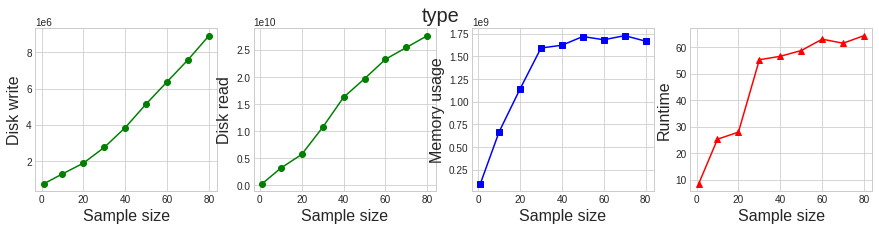

In [9]:
# Typer command Plots
benchmark.multibench.plot_resources(multibench_results, sample_sizes, "type")